# Wine Quality Analysis

<img src="https://thumbor.forbes.com/thumbor/fit-in/1200x0/filters%3Aformat%28jpg%29/https%3A%2F%2Fspecials-images.forbesimg.com%2Fdam%2Fimageserve%2F1133888244%2F0x0.jpg%3Ffit%3Dscale" width="600px" />

This notebook analyse a database of **red** and **white** variants of the Portuguese "Vinho Verde" wine based on wine **physicochemical test results** and quality scores that experts assign to each wine sample.

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_theme(style='whitegrid')

In [3]:
full_df = pd.read_csv('data/winequalityN.csv')

# Database Overview

In [4]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [5]:
full_df.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.0              0.27         0.36            20.7   
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality  
0       0.45      8.8        6  
1       0.49      9.5        6  
2       0.44     10.1        6  
3       0.40      9.9        6  
4       0.40      9.9        6

In [6]:
full_df.describe().transpose()

count        mean        std      min       25%  \
fixed acidity         6487.0    7.216579   1.296750  3.80000   6.40000   
volatile acidity      6489.0    0.339691   0.164649  0.08000   0.23000   
citric acid           6494.0    0.318722   0.145265  0.00000   0.25000   
residual sugar        6495.0    5.444326   4.758125  0.60000   1.80000   
chlorides             6495.0    0.056042   0.035036  0.00900   0.03800   
free sulfur dioxide   6497.0   30.525319  17.749400  1.00000  17.00000   
total sulfur dioxide  6497.0  115.744574  56.521855  6.00000  77.00000   
density               6497.0    0.994697   0.002999  0.98711   0.99234   
pH                    6488.0    3.218395   0.160748  2.72000   3.11000   
sulphates             6493.0    0.531215   0.148814  0.22000   0.43000   
alcohol               6497.0   10.491801   1.192712  8.00000   9.50000   
quality               6497.0    5.818378   0.873255  3.00000   5.00000   

                            50%        75%        max  
fixed acidity           7.00000    7.70000   15.90000  
volatile acidity        0.29000    0.40000    1.58000  
citric acid             0.31000    0.39000    1.66000  
residual sugar          3.00000    8.10000   65.80000  
chlorides               0.04700    0.06500    0.61100  
free sulfur dioxide    29.00000   41.00000  289.00000  
total sulfur dioxide  118.00000  156.00000  440.00000  
density                 0.99489    0.99699    1.03898  
pH                      3.21000    3.32000    4.01000  
sulphates               0.51000    0.60000    2.00000  
alcohol                10.30000   11.30000   14.90000  
quality                 6.00000    6.00000    9.00000

## Missing Values

In [7]:
full_df.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [8]:
# todo: how to handle?

In [9]:
full_df[full_df['fixed acidity'].isna()][['fixed acidity', 'pH']]

fixed acidity    pH
17              NaN  3.33
174             NaN  3.09
249             NaN  3.38
267             NaN  3.34
368             NaN  3.17
518             NaN  3.43
1079            NaN  3.29
2902            NaN  3.27
6428            NaN   NaN
6429            NaN   NaN

## Wine Quality Distribution

**Wine quality** measures from **3 to 9** according to the observations in the training set. **Wine quality 5, 6 and 7** were the most frequent:

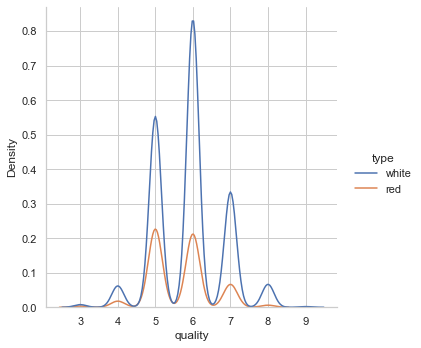

In [10]:
sns.displot(data=full_df, x='quality', hue='type', kind='kde')

With this we would like to simplify quality analys by adding **low**, **average** and **high quality** groups:

In [11]:
def impute_quality_group(quality):
    if quality <= 4:
        return 0 # low
    if quality > 4 and quality <= 7:
        return 1 # average
    if quality >= 8:
        return 2 # high

full_df['quality_group'] = full_df['quality'].apply(impute_quality_group)

# Wine Physicochemical Analysis

## Wine Type

Our wine collection is represented in **red** and **white** wine types. Red and white wines are not only different because of the type of grapes and color. Actually, technology of producing these types of wine is quite different:

- **Red wines** are fermented with the **grape skins** and **seeds** and white wines are **not**. This is because all the color in red wine comes from the **skins and seeds of the grapes**.

- The largest difference between **red winemaking** and **white winemaking** is the oxidation that causes the wines to lose their floral and fruit notes in exchange for rich, nutty flavors and more smoothness.

More Info:
- https://winefolly.com/tips/red-wine-vs-white-wine-the-real-differences/
- https://www.healthline.com/nutrition/red-vs-white-wine

The training set is **imbalanced** with respect to wine types: there are much more red wines than white ones (75% vs 25%):

In [12]:
full_df['quality'].value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

In [13]:
full_df['type'].value_counts()

white    4898
red      1599
Name: type, dtype: int64

**Wine quality** doesn't seem to be dependent on the wine type:

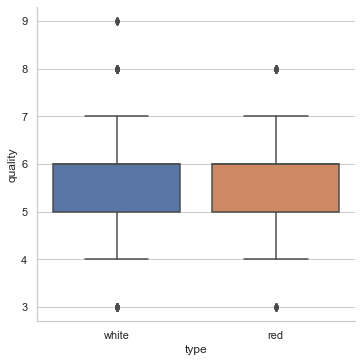

In [14]:
sns.catplot(data=full_df, x='type', y='quality', kind='box')

However, it's reasonable to think that physicochemical test results for "good" and "bad" wines will be different and depends on wine type. So it may be helpful to **separate** our training set **by wine type** for further investigation:

In [15]:
red_wine_df = full_df[full_df['type'] == 'red']
white_wine_df = full_df[full_df['type'] == 'white']

Having wine type dataframes, we can see how **quality** of each type **correlates** with the rest of wine characteristics:

Text(0.5, 1.0, 'White Wine')

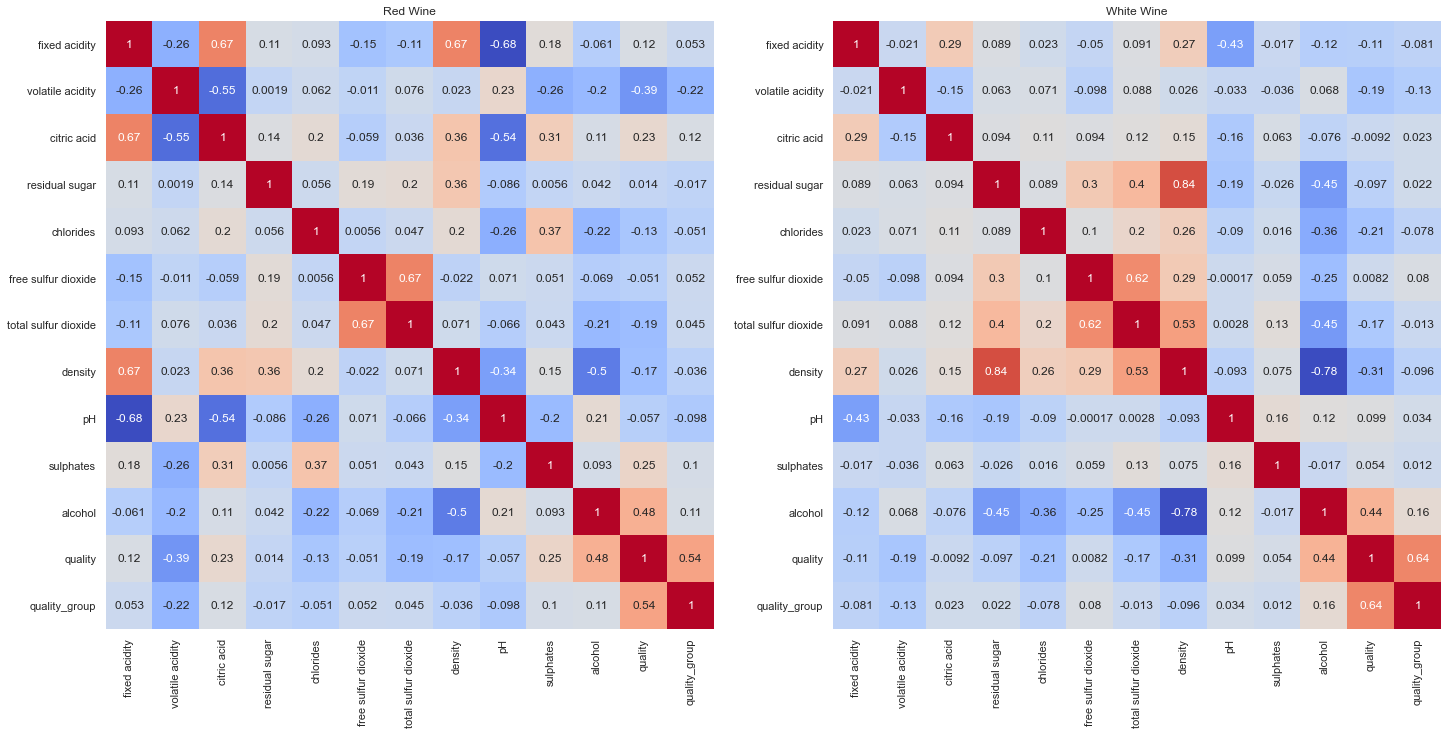

In [16]:
fig, (ax0, ax1) = plt.subplots(1, 2, constrained_layout=True, figsize=(20, 20))

sns.heatmap(red_wine_df.corr(), annot=True, square=True, cmap='coolwarm', cbar=False, ax=ax0)
ax0.set_title('Red Wine')

sns.heatmap(white_wine_df.corr(), annot=True, square=True, cmap='coolwarm', cbar=False, ax=ax1)
ax1.set_title('White Wine')

**Red Wine Quality Insights**:
- **Alchohol** has possitive correlation with **Quality** (0.48)
- **Sulphates** has possitive correlation with **Quality** (0.25)
- **Citric Acidity** has possitive correlation with **Quality** (0.23)
- **Fixed Acidity** has possitive correlation with **Quality** (0.12)
- **Chlorides** has negative correlation with **Quality** (-0.13)
- **Density** has negative correlation with **Quality** (-0.17)
- **Total Sulfure Dioxide** has negative correlation with **Quality** (-0.19)
- **Volatile Acidity** has negative correlation with **Quality** (-0.39)

**White Wine Quality Insights**:
- **Alchohol** has possitive correlation with **Quality** (0.44)
- **Fixed Acidity** has negative correlation with **Quality** (-0.11)
- **Total Sulfure Dioxide** has negative correlation with **Quality** (-0.17)
- **Volatile Acidity** has negative correlation with **Quality** (-0.19)
- **Chlorides** has negative correlation with **Quality** (-0.21)
- **Density** has negative correlation with **Quality** (-0.31)

## Acidity and pH

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/70/Wine_grape_diagram_en.svg/2560px-Wine_grape_diagram_en.svg.png" width="600px" />

The **acids** in wine are an important component in both winemaking and the finished product of wine. They are present in both **grapes and wine**, having direct influences on the **color, balance and taste** of the wine as well as the **growth and vitality of yeast** during fermentation and **protecting the wine from bacteria**. 

Here is acidity information we have been given:
- **fixed acidity** (tartaric acid - $g/dm^3$) - most acids involved with wine or fixed or nonvolatile (do not evaporate readily)
- **volatile acidity** (acetic acid - $g/dm^3$) - the amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste
- **citric acid** ($g/dm^3$) - found in small quantities, citric acid can add "freshness" and flavor to wines
- **pH** - describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4 on the pH scale

More Info:
- https://waterhouse.ucdavis.edu/whats-in-wine/fixed-acidity
- http://www.oiv.int/public/medias/3732/oiv-ma-as313-02.pdf
- https://waterhouse.ucdavis.edu/whats-in-wine/volatile-acidity
- https://www.decanter.com/learn/volatile-acidity-va-45532/
- https://extension.psu.edu/volatile-acidity-in-wine

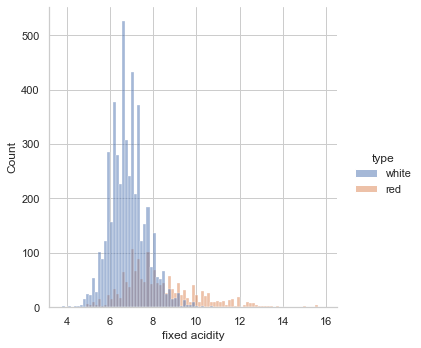

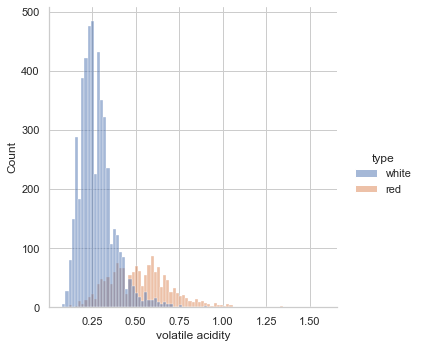

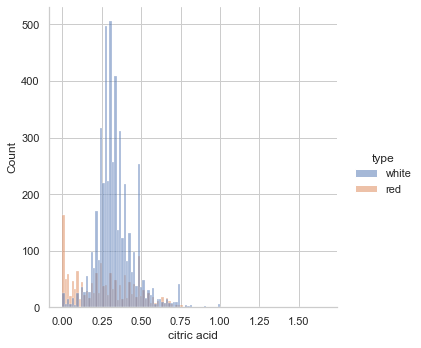

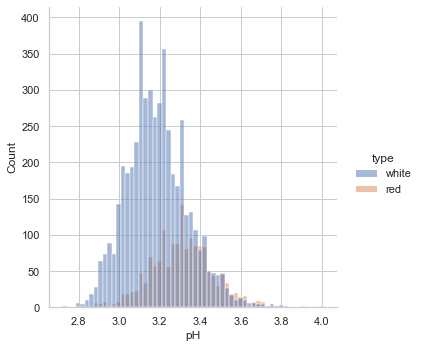

In [59]:
sns.displot(data=full_df, x='fixed acidity', hue='type')
sns.displot(data=full_df, x='volatile acidity', hue='type')
sns.displot(data=full_df, x='citric acid', hue='type')
sns.displot(data=full_df, x='pH', hue='type')

### Fixed Acidity

**Tartaric acid** is, from a winemaking perspective, the most important in wine due to the prominent role it plays in maintaining the chemical stability of the wine and its color and finally in influencing the taste of the finished wine.

Most of the **acids** involved with wine are **fixed acids** with the notable exception of **acetic acid**, mostly found in vinegar, which is volatile and can contribute to the wine fault known as volatile acidity.

**Fixed accidity** differently affects **red and white wine quality**:
- **Red wine** becomes better **quality** with increasing **fixed acidity**
- Conversing, **white wine** quality degrades with increasing **fixed acidity**

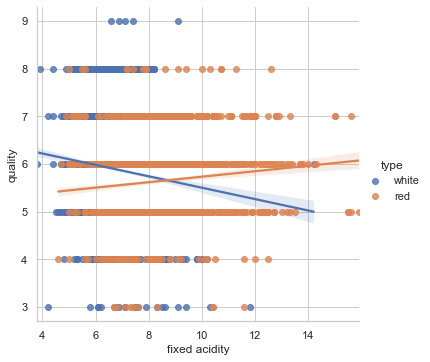

In [20]:
sns.lmplot(data=full_df, x='fixed acidity', y='quality', hue='type')

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2)

full_df['fixed_acidity_log'] = np.log1p(full_df['fixed acidity'])

stats.probplot(full_df['fixed acidity'], dist=stats.norm, plot=ax0)
stats.probplot(full_df['fixed_acidity_log'], dist=stats.norm, plot=ax1);

### Volatile Acidity

<img src="https://i.insider.com/5ef6191e5af6cc6d7604ae44?width=2000&format=jpeg&auto=webp" width="600px" />

**Volatile acidity** is only good if it's added intensionally to the wine production and in small dozes. Increasing in **volatile acidity** is killing **wine quality**:

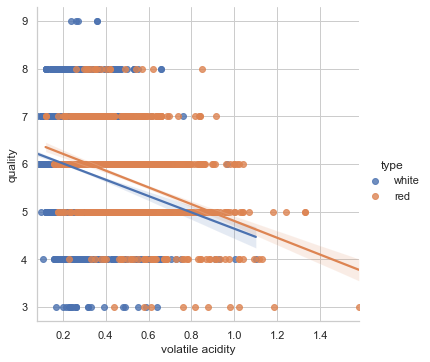

In [21]:
sns.lmplot(data=full_df, x='volatile acidity', y='quality', hue='type')

### Citric Acid

<img src="https://images-na.ssl-images-amazon.com/images/I/41VHzHjkVvL.jpg" width="600px" />

The **citric acid** most commonly found in wine is commercially produced acid supplements derived from fermenting sucrose solutions. These inexpensive supplements can be used by winemakers in acidification to boost the **wine's total acidity** and prevent **ferric hazes**. It is used less frequently than **tartaric and malic** due to the aggressive **citric flavors** it can add to the wine. When **citric acid** is added, it is always done after primary alcohol fermentation has been completed due to the tendency of yeast to convert citric into acetic acid. 

More Info:
- https://wineserver.ucdavis.edu/industry-info/enology/methods-and-techniques/common-chemical-reagents/citric-acid

**Citric Acidity** improves **red wine quality** and has slightly negative impact on the **white wine quality**:

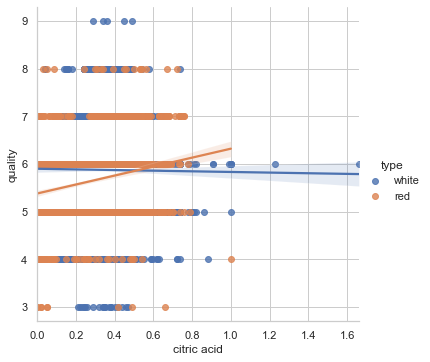

In [22]:
sns.lmplot(data=full_df, x='citric acid', y='quality', hue='type')

<img src="https://253qv1sx4ey389p9wtpp9sj0-wpengine.netdna-ssl.com/wp-content/uploads/2019/06/PH_level_6.jpg" width="600px" />

The **pH** scale runs from **0 to 14**, from **very acidic to very basic, or alkaline**. 
**pH** affects almost every aspect of the wine: flavor, aroma, color, and potentially even quality.

Lower **pH** numbers mean higher amounts of hydrogen ions, and therefore a more acidic wine. In comparison, lemon juice usually has a pH between 2 and 3, while orange juice and wine are generally between 3 and 4, with some wines reaching slightly beyond that, to high **2s or low 4s**. For each full point increase in pH, the level of acidity is 10 times more acidic as you go up, so the difference between a pH of 3 and a pH of 4 is very significant.

More Info:
- https://daily.sevenfifty.com/how-winemakers-analyze-ph-and-its-impact-on-wine/
- https://rstudio-pubs-static.s3.amazonaws.com/277109_1f7df6787d344858af90b5a5d6c1ef65.html

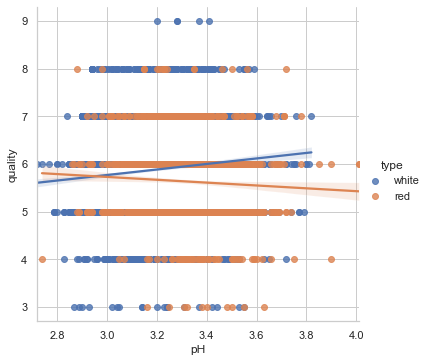

In [23]:
sns.lmplot(data=full_df, x='pH', y='quality', hue='type')

**pH** shows the same picture as **fixed acidity**. **Red wine quality** becomes higher with higher acidity (lower pH value) and **white wine quality** becomes higher as acidity reduces.

## Sugar, Alcohol and Density

<img src="https://upload.wikimedia.org/wikipedia/commons/d/d5/Mthomebrew_must.JPG" width="600px" />

The process of **fermentation** in winemaking turns grape juice into an alcoholic beverage. During fermentation, **yeasts** transform sugars present in the juice into ethanol and carbon dioxide. In winemaking, the temperature and speed of fermentation are important considerations as well as the levels of oxygen present in the must at the start of the fermentation.

Here is a list of wine properties related to **fermentation** process:

- **residual sugar** ($g/dm^3$) - the amount of **sugar** remaining after **fermentation stops**, it's rare to find wines with less than 1 gram/liter and wines with greater than 45 grams/liter are considered sweet
- **alcohol** (% by volume) - the percent alcohol content of the wine
- **density** ($g/cm^3$) - the density of water is close to that of water depending on the percent alcohol and sugar content

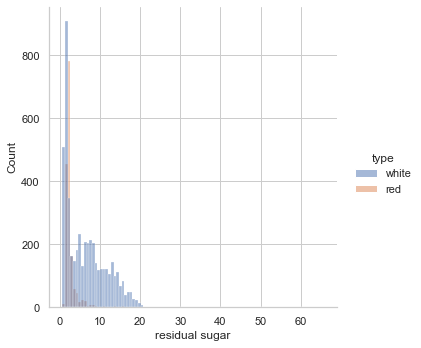

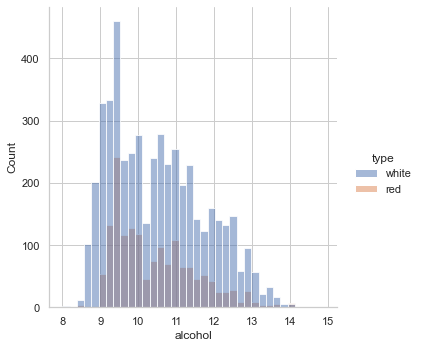

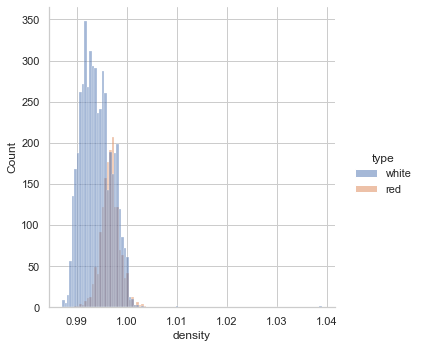

In [24]:
sns.displot(data=full_df, x='residual sugar', hue='type')
sns.displot(data=full_df, x='alcohol', hue='type')
sns.displot(data=full_df, x='density', hue='type')

<img src="https://media.winefolly.com/Residual-Sugar-wine.png" width="600px" />

**Residual sugar** is from natural grape sugars leftover in a wine after the alcoholic fermentation finishes.

More Info:
- https://winefolly.com/deep-dive/what-is-residual-sugar-in-wine/

Here is a quick ranges of residual sugar by wine type:

**White Wine**:
- Total: 0.6-65.8 g/gm^3
- In Low Tier: 0.7-17.55 g/gm^3
- In High Tier: 0.8-14.8 g/gm^3

**Red Wine**:
- Total: 0.9-15.5 g/dm^3
- In Low Tier: 1.2-12.9 g/dm^3
- In High Tier: 1.4-6.4 g/dm^3

**Resigual sugar** has slightly possitive correlation with **red wine quality** and slightly negative correlation with **white wine quality**.

In [25]:
red_wine_df[red_wine_df['quality_group'] == 2]['residual sugar'].describe()

count    18.000000
mean      2.577778
std       1.295038
min       1.400000
25%       1.800000
50%       2.100000
75%       2.600000
max       6.400000
Name: residual sugar, dtype: float64

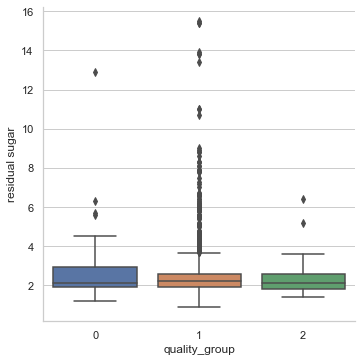

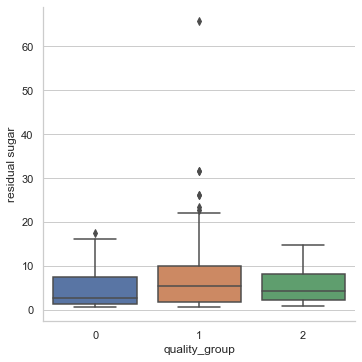

In [26]:
sns.catplot(data=red_wine_df, x='quality_group', y='residual sugar', kind='box')
sns.catplot(data=white_wine_df, x='quality_group', y='residual sugar', kind='box')

**Percentage of alcohol** has a great possitive correlation with **wine quality**:

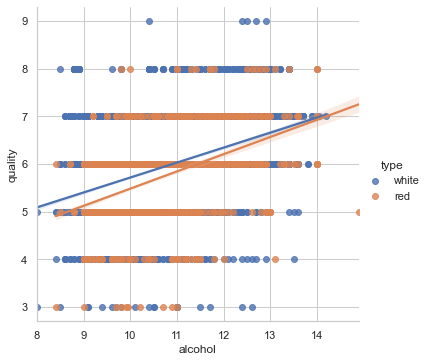

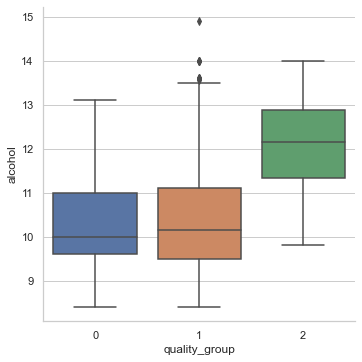

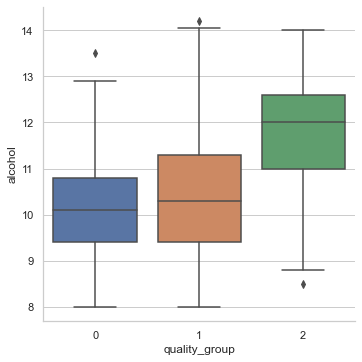

In [27]:
sns.lmplot(data=full_df, x='alcohol', y='quality', hue='type')
sns.catplot(data=red_wine_df, x='quality_group', y='alcohol', kind='box')
sns.catplot(data=white_wine_df, x='quality_group', y='alcohol', kind='box')

Prior to fermentation, wine will contain **sugars** which will make the liquid more **dense**. When the **wine** is undergoing fermentation the **sugars** in the liquid are converted by the yeast into **alcohol**. **Alcohol in water** is **less dense** than sugar in water:

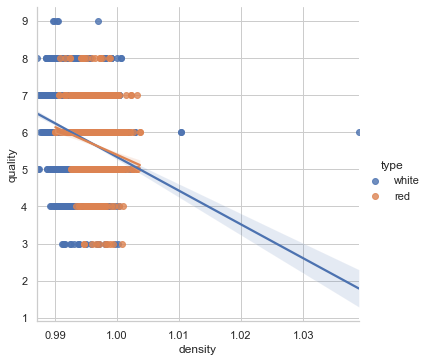

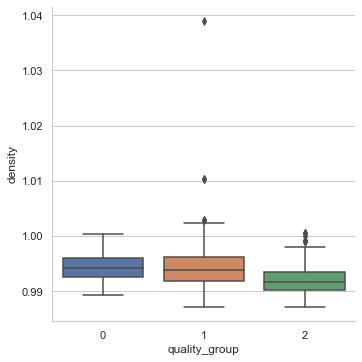

In [28]:
sns.lmplot(data=full_df, x='density', y='quality', hue='type')
sns.catplot(data=white_wine_df, x='quality_group', y='density', kind='box')

## Sulfur Dioxide and Sulphates

<img src="https://media.winefolly.com/are-sulfites-in-wine-bad-for-health.jpg" width="600px" />

**Sulfites** help preserve wine and slow chemical reactions, which cause a wine to go bad. Experts believe that **higher sulfurous** content causes a **duller taste** in wine, and that high potency of **sulfite ions** presents a health risk and speeds up the wine’s fermentation process. This suggests that **higher sulphate** contents tend to correspond with **lower wine quality**. 

The presence of another type of sulfate, **sulfur dioxide**, is thought to help rid the wine of a wide variety of bacteria (good and bad); this seems to **lower the wine quality as well** because it dulls the wine’s fermentation process.

- **free sulfur dioxide** ($mg/dm^3$) - the free form of $SO_{2}$ exists in equilibrium between molecular $SO_{2}$ (as a dissolved gas) and bisulfite ion; it prevents microbial growth and the oxidation of wine
- **total sulfur dioxide** ($mg/dm^3$) - amount of free and bound forms of $SO_{2}$; in low concentrations, $SO_{2}$ is mostly undetectable in wine, but at free $SO_{2}$ concentrations over 50 ppm, $SO_{2}$ becomes evident in the nose and taste of wine
- **sulphates** (potassium sulphate - $g/dm^3$) - a wine additive which can contribute to sulfur dioxide gas ($SO_{2}$) levels, wich acts as an antimicrobial and antioxidant

More Info:
- https://www.decanter.com/learn/wine-terminology/sulfites-in-wine-friend-or-foe-295931/
- https://link.springer.com/chapter/10.1007/978-1-4757-6255-6_12
- https://winefolly.com/deep-dive/sulfites-in-wine/
- https://www.healthline.com/nutrition/sulfites-in-wine

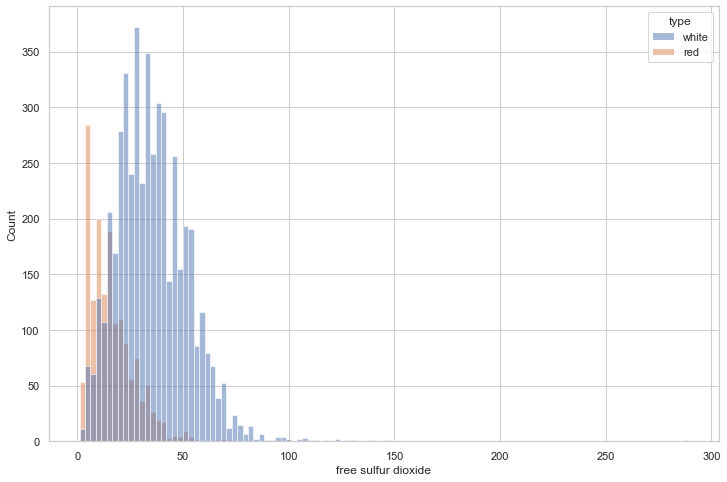

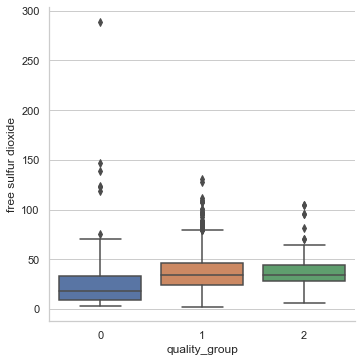

In [29]:
sns.histplot(data=full_df, x='free sulfur dioxide', hue='type')
sns.catplot(data=white_wine_df, x='quality_group', y='free sulfur dioxide', kind='box')

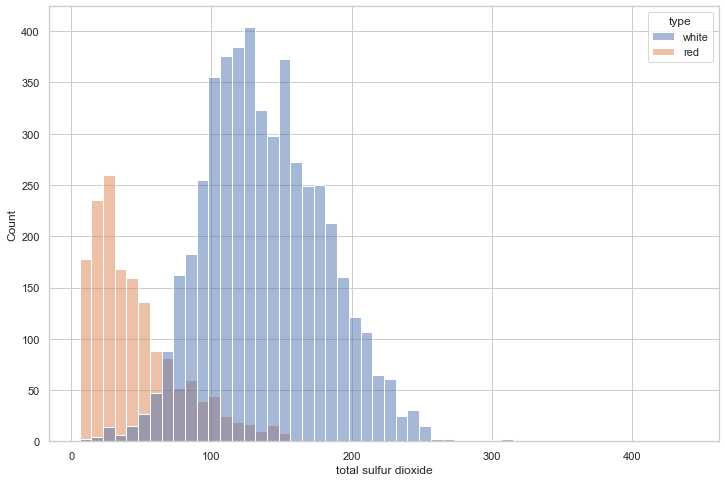

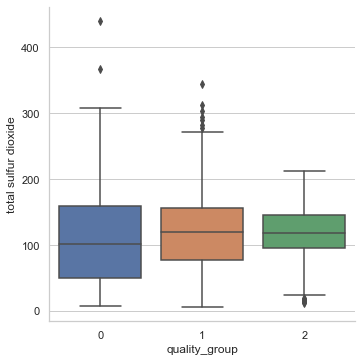

In [30]:
sns.histplot(data=full_df, x='total sulfur dioxide', hue='type')
sns.catplot(data=full_df, x='quality_group', y='total sulfur dioxide', kind='box')

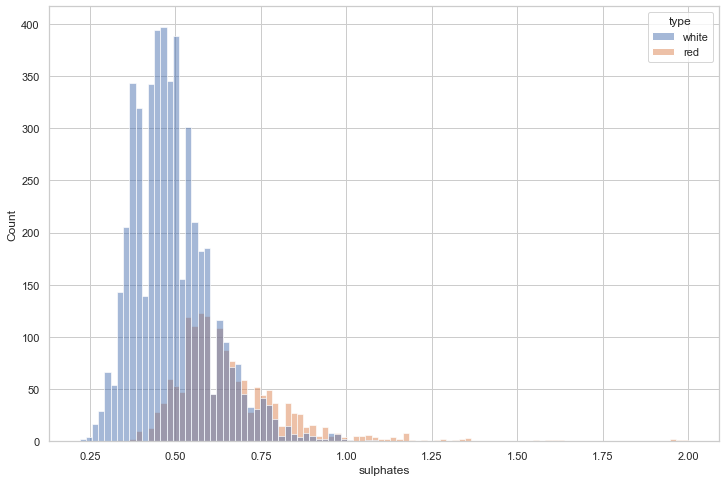

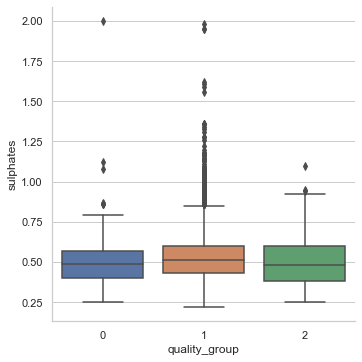

In [57]:
sns.histplot(data=full_df, x='sulphates', hue='type')
sns.catplot(data=full_df, x='quality_group', y='sulphates', kind='box')

## Chlorides

Chloride concentration in the wine is influenced by terroir and its highest levels are found in wines coming from countries where irrigation is carried out using salty water or in areas with brackish terrains.

**Chlorides** (**sodium chloride** - $g/dm^3$) - the amount of **salt** in the wine

<AxesSubplot:xlabel='chlorides_log', ylabel='Count'>

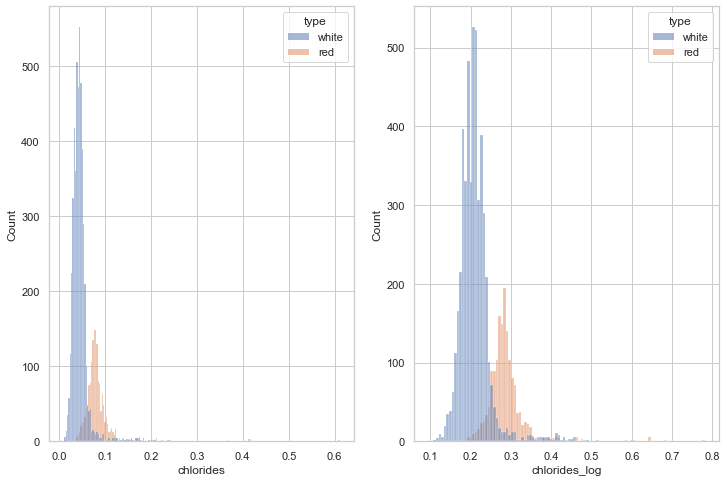

In [32]:
full_df['chlorides_log'] = np.sqrt(full_df['chlorides'])

_, (ax0, ax1) = plt.subplots(1, 2)

sns.histplot(data=full_df, x='chlorides', hue='type', ax=ax0)
sns.histplot(data=full_df, x='chlorides_log', hue='type', ax=ax1)

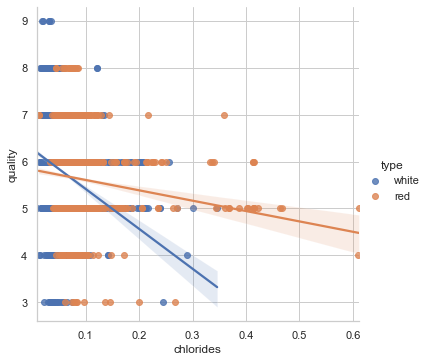

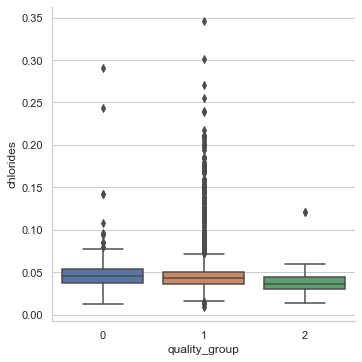

In [33]:
sns.lmplot(data=full_df, x='chlorides', y='quality', hue='type')
sns.catplot(data=white_wine_df, x='quality_group', y='chlorides', kind='box')

## Credits

- https://bibinmjose.github.io/RedWineDataAnalysis/
- https://s3.amazonaws.com/udacity-hosted-downloads/ud651/wineQualityInfo.txt